In [7]:
#!/usr/bin/env python3
"""
occupancy_model_comparison.py

Run eDNAoccupancy models via R (rpy2) for:
  • intercept‐only
  • all 1‐covariate, 2‐covariate, 3‐covariate, and 4‐covariate combinations

Make sure to set `output_dir` to a writable path on your system.
"""

import os
import pandas as pd
import itertools
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

def get_criterion(fit_var: str, fn: str) -> float:
    """Extract numeric criterion from R (posteriorPredictiveLoss or WAIC)."""
    return float(ro.r(f"{fn}({fit_var}, burnin=1000)$criterion")[0])

def main():
    # ─── User settings ───────────────────────────────────────────────────────────
    # path where R can write mc.csv (and where result CSV will go)
    output_dir = "/Users/sarawut/Desktop/DNAOccupancy/eDNAoccupancy-master/2022"
    # adjust these two paths if your files are elsewhere:
    det_csv    = os.path.join(output_dir, "CPITSDetectionData2022.csv")
    survey_csv = os.path.join(output_dir, "CPITSSurveyData2022.csv")
    # ──────────────────────────────────────────────────────────────────────────────

    # 1) ensure the output directory exists
    if not os.path.isdir(output_dir):
        raise FileNotFoundError(f"Please create or correct output_dir: {output_dir}")

    # 2) Activate pandas → R data.frame conversion
    pandas2ri.activate()

    # 3) Import the eDNAoccupancy R package
    edno = importr('eDNAoccupancy')

    # 4) Load your data
    det_df    = pd.read_csv(det_csv)
    survey_df = pd.read_csv(survey_csv)

    # 5) Push into R
    ro.globalenv['CPITSDetectionData2022'] = det_df
    ro.globalenv['CPITSSurveyData2022']   = survey_df

    # 6) Switch R’s working directory so R can write mc.csv here
    ro.r(f'setwd("{output_dir}")')

    # 7) Compute detection matrices & scale covariates
    ro.r('CPITSDetections <- occData('
         'CPITSDetectionData2022, '
         'siteColName="site", '
         'sampleColName="sample")')
    ro.r('CPITSSurveyData2022.sc <- scaleData(CPITSSurveyData2022)')

    # 8) Define your covariates (edit if yours differ)
    covariates = ["tds", "ph", "con", "tem"]

    # 9) Prepare container for results
    results = []

    # 10) Fit the intercept‐only model
    ro.r('set.seed(157)')
    ro.r('fit0 <- occModel('
         'formulaSite=~1, '
         'formulaSiteAndSample=~1, '
         'formulaReplicate=~1, '
         'detectionMats=CPITSDetections, '
         'niter=11000, niterInterval=5000)')
    pplc0 = get_criterion('fit0', 'posteriorPredictiveLoss')
    waic0 = get_criterion('fit0', 'WAIC')
    results.append({
        "Model":              "no covariates",
        "ψ(site)":            "~1",
        "θ(site+sample)":     "~1",
        "p(replicate)":       "~1",
        "PPLC":               round(pplc0, 1),
        "WAIC":               round(waic0, 3)
    })

    # 11) Loop through all combos of 1–4 covariates
    for k in range(1, len(covariates) + 1):
        for combo in itertools.combinations(covariates, k):
            theta_formula = "~ " + " + ".join(combo)
            ro.r('set.seed(157)')
            ro.r(f'fit <- occModel('
                 f'formulaSite=~1, '
                 f'formulaSiteAndSample={theta_formula}, '
                 f'formulaReplicate=~1, '
                 f'detectionMats=CPITSDetections, '
                 f'siteData=CPITSSurveyData2022.sc, '
                 f'niter=11000, niterInterval=5000)')
            pplc_val = get_criterion('fit', 'posteriorPredictiveLoss')
            waic_val = get_criterion('fit', 'WAIC')

            results.append({
                "Model":          f"θ({','.join(combo)})",
                "ψ(site)":        "~1",
                "θ(site+sample)": theta_formula,
                "p(replicate)":   "~1",
                "PPLC":           round(pplc_val, 1),
                "WAIC":           round(waic_val, 3)
            })

    # 12) Assemble final table
    results_df = pd.DataFrame(results)

    # 13) Print to console
    print("\n=== Model comparison results ===")
    print(results_df.to_string(index=False))

    # 14) Save to CSV in output_dir
    out_csv = os.path.join(output_dir, "model_comparison_results.csv")
    results_df.to_csv(out_csv, index=False)
    print(f"\nSaved results to {out_csv}")

if __name__ == "__main__":
    main()


Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.216649  minutes 
..... drawing sample # 10000  after  0.4223699  minutes 
Completed  11000  draws of MCMC algorithm 
Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2188501  minutes 
..... drawing sample # 10000  after  0.4309015  minutes 
Completed  11000  draws of MCMC algorithm 
Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2210116  minutes 
..... drawing sample # 10000  after  0.4547926  minutes 
Completed  11000  draws of MCMC algorithm 
Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2241258  minutes 
..... drawing sample # 10000  after  0.4451128  minutes 
Completed  11000  draws of MCMC algorithm 
Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2735043  minutes 
..... drawing sample # 10000  after  0.5602862  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 



Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2289584  minutes 
..... drawing sample # 10000  after  0.4510062  minutes 
Completed  11000  draws of MCMC algorithm 
Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.3013497  minutes 
..... drawing sample # 10000  after  0.6163366  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 



Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2897426  minutes 
..... drawing sample # 10000  after  0.579736  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 



Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2241628  minutes 
..... drawing sample # 10000  after  0.4602832  minutes 
Completed  11000  draws of MCMC algorithm 
Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2972259  minutes 
..... drawing sample # 10000  after  0.5786532  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 



Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2716705  minutes 
..... drawing sample # 10000  after  0.5392748  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 



Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2944247  minutes 
..... drawing sample # 10000  after  0.5858377  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 



Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2854784  minutes 
..... drawing sample # 10000  after  0.5731505  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 



Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2897923  minutes 
..... drawing sample # 10000  after  0.5868195  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 



Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2938278  minutes 
..... drawing sample # 10000  after  0.5835418  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 



Begin MCMC sampling: 
 
..... drawing sample # 5000  after  0.2822628  minutes 
..... drawing sample # 10000  after  0.5731562  minutes 
Completed  11000  draws of MCMC algorithm 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: glm.fit: fitted probabilities numerically 0 or 1 occurred 




=== Model comparison results ===
            Model ψ(site)         θ(site+sample) p(replicate)  PPLC   WAIC
    no covariates      ~1                     ~1           ~1  24.7 36.318
           θ(tds)      ~1                  ~ tds           ~1  24.9 36.646
            θ(ph)      ~1                   ~ ph           ~1  24.8 36.510
           θ(con)      ~1                  ~ con           ~1  24.8 36.738
           θ(tem)      ~1                  ~ tem           ~1  24.5 34.705
        θ(tds,ph)      ~1             ~ tds + ph           ~1  24.9 36.784
       θ(tds,con)      ~1            ~ tds + con           ~1  24.5 34.549
       θ(tds,tem)      ~1            ~ tds + tem           ~1  24.5 34.672
        θ(ph,con)      ~1             ~ ph + con           ~1  24.9 36.842
        θ(ph,tem)      ~1             ~ ph + tem           ~1  24.5 34.624
       θ(con,tem)      ~1            ~ con + tem           ~1  24.5 34.720
    θ(tds,ph,con)      ~1       ~ tds + ph + con           ~1  24.

                Model ψ(site)          θ(site+sample) p(replicate)  PPLC   
0       no covariates      ~1                      ~1           ~1  24.7  \
1              θ(tds)      ~1                   ~ tds           ~1  24.9   
2               θ(ph)      ~1                    ~ ph           ~1  24.8   
3              θ(con)      ~1                   ~ con           ~1  24.8   
4              θ(tem)      ~1                   ~ tem           ~1  24.5   
5           θ(tds,ph)      ~1              ~ tds + ph           ~1  24.9   
6          θ(tds,con)      ~1             ~ tds + con           ~1  24.5   
7          θ(tds,tem)      ~1             ~ tds + tem           ~1  24.5   
8           θ(ph,con)      ~1              ~ ph + con           ~1  24.9   
9           θ(ph,tem)      ~1              ~ ph + tem           ~1  24.5   
10         θ(con,tem)      ~1             ~ con + tem           ~1  24.5   
11      θ(tds,ph,con)      ~1        ~ tds + ph + con           ~1  24.5   
12      θ(td

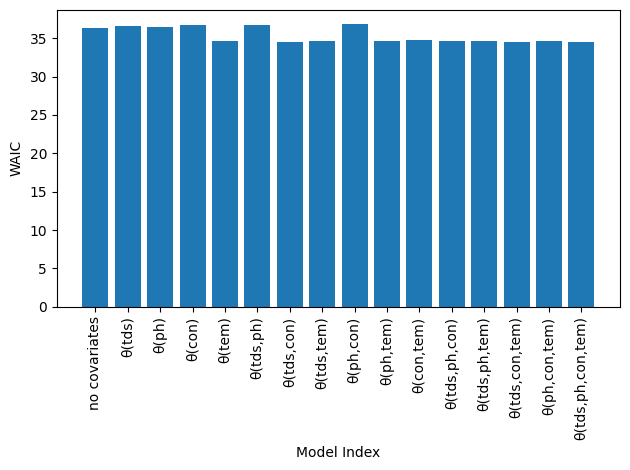

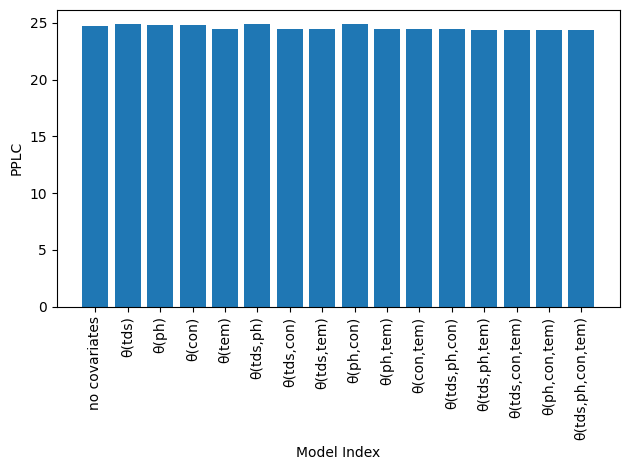

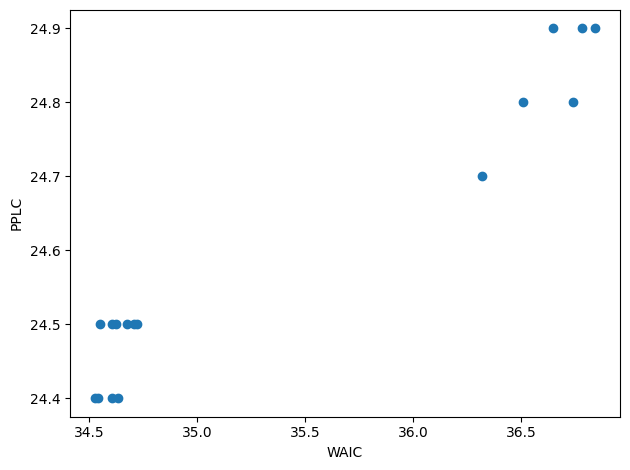

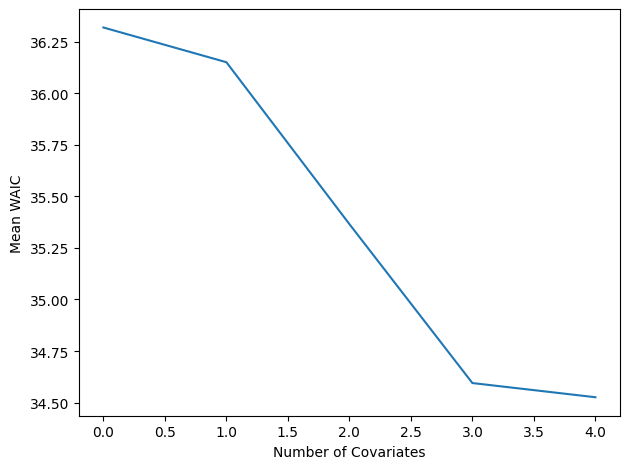

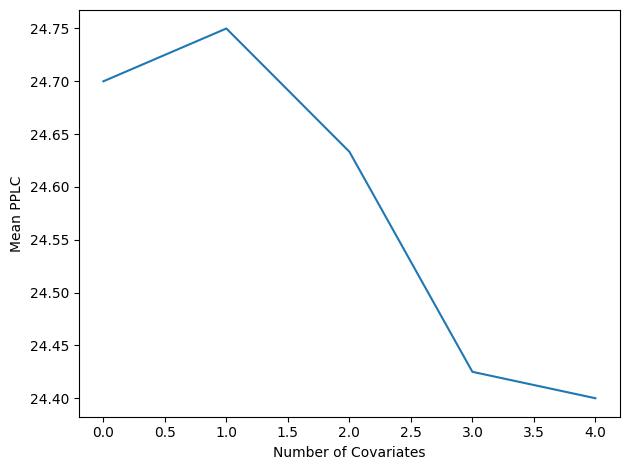

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read in the previously saved CSV
results_df = pd.read_csv("/Users/sarawut/Desktop/DNAOccupancy/eDNAoccupancy-master/2022/model_comparison_results.csv")

# 2) Add number of covariates
results_df['num_cov'] = results_df['Model'].apply(
    lambda x: 0 if x == "no covariates" else x.count(',') + 1
)

# 3) Display the table
print(results_df)

# 4) WAIC bar plot
plt.figure()
plt.bar(range(len(results_df)), results_df['WAIC'])
plt.xlabel('Model Index')
plt.ylabel('WAIC')
plt.xticks(range(len(results_df)), results_df['Model'], rotation=90)
plt.tight_layout()
plt.show()

# 5) PPLC bar plot
plt.figure()
plt.bar(range(len(results_df)), results_df['PPLC'])
plt.xlabel('Model Index')
plt.ylabel('PPLC')
plt.xticks(range(len(results_df)), results_df['Model'], rotation=90)
plt.tight_layout()
plt.show()

# 6) PPLC vs WAIC scatter
plt.figure()
plt.scatter(results_df['WAIC'], results_df['PPLC'])
plt.xlabel('WAIC')
plt.ylabel('PPLC')
plt.tight_layout()
plt.show()

# 7) Mean WAIC by covariate count
mean_waic = results_df.groupby('num_cov')['WAIC'].mean().reset_index()
plt.figure()
plt.plot(mean_waic['num_cov'], mean_waic['WAIC'])
plt.xlabel('Number of Covariates')
plt.ylabel('Mean WAIC')
plt.tight_layout()
plt.show()

# 8) Mean PPLC by covariate count
mean_pplc = results_df.groupby('num_cov')['PPLC'].mean().reset_index()
plt.figure()
plt.plot(mean_pplc['num_cov'], mean_pplc['PPLC'])
plt.xlabel('Number of Covariates')
plt.ylabel('Mean PPLC')
plt.tight_layout()
plt.show()
